In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [110]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit, KFold, TimeSeriesSplit, cross_val_score
from sklearn.utils import resample
from functools import partial

# New York Stock Exchange

In [13]:
prices = pd.read_csv('./prices_nyse.csv', index_col=0)
prices.index = pd.to_datetime(prices.index, format='%Y-%m-%d')
print(prices.shape)
prices.head()

(1762, 5)


,AAPL,FB,NFLX,V,XOM
time,,,,,
2010-01-04,214.009998,NaN,53.479999,88.139999,69.150002
2010-01-05,214.379993,NaN,51.510001,87.129997,69.419998
2010-01-06,210.969995,NaN,53.319999,85.959999,70.019997
2010-01-07,210.580000,NaN,52.400001,86.760002,69.800003
2010-01-08,211.980005,NaN,53.300002,87.000000,69.519997


In [14]:
# get relevant functions

def percent_change(series):
    # collect all but the last value of this window, then the final value
    prev_vals = series[:-1]
    last_val = series[-1]
    
    # calculate the %change between the last val and mean of prev vals
    percent_change = (last_val - np.mean(prev_vals)) / np.mean(prev_vals)
    
    return percent_change

def replace_outliers(series):
    # calculate the absolute difference of each point from the series mean
    abs_diff_from_mean = np.abs(series - np.mean(series))
    
    # calculate a mask for the diff that are > 3 standard deviations from mean
    this_mask = abs_diff_from_mean > (np.std(series) * 3)
    
    # replace these values with the median across the data
    series[this_mask] = np.nanmedian(series)
    
    return series

## Creating time-shifted features

In [26]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [23]:
# choose AAPL from prices
price = prices[['AAPL']]

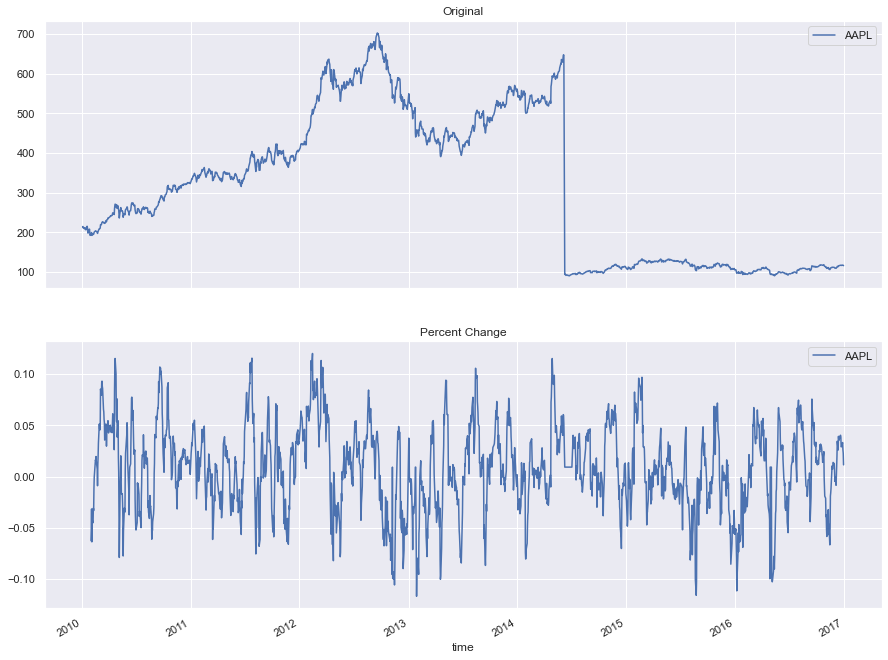

In [28]:
# in this exercise, we use percent change time series
# so let's transform price first
price_perc = price.rolling(20).aggregate(percent_change)
price_perc = price_perc.apply(replace_outliers)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12),
                               sharex=True)

price.plot(ax=ax1)
price_perc.plot(ax=ax2)

ax1.set(title='Original')
ax2.set(title='Percent Change')

plt.show()

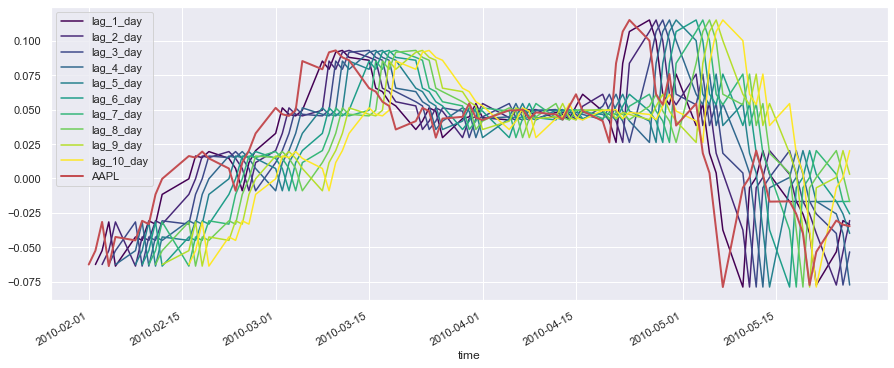

In [31]:
# these are the "time lags"
shifts = np.arange(1, 11).astype(int)

# use dictionary comprehension to create name:value pairs,
# one pair per shift
shifted_data = {f'lag_{day_shift}_day': price_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# convert into a DataFrame for subsequent use
price_perc_shifted = pd.DataFrame(shifted_data)

# plot the first 100 samples of each
fig, ax = plt.subplots(figsize=(15, 6))

price_perc_shifted.iloc[:100].plot(ax=ax,
                                   cmap=plt.cm.viridis)
price_perc.iloc[:100].plot(ax=ax,
                           color='r', lw=2)
ax.legend(loc='best')

plt.show()

## Special case: Auto-regressive models

In [34]:
# replace missing values with the median for each column
X = price_perc_shifted.fillna(np.nanmedian(price_perc_shifted))
y = price_perc.fillna(np.nanmedian(price_perc))

# fit a Ridge model
model = Ridge()
model.fit(X, y)

Ridge()

## Visualize regression coefficients

In [49]:
def visualize_coefficients(coefs, names, ax):
    # make a bar plot for the coefs, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name',
           ylabel='Coefficient value')
    
    # set the formatting so it looks nice
    plt.setp(ax.get_xticklabels(), 
             rotation=45,
             horizontalalignment='right')
    
    return ax

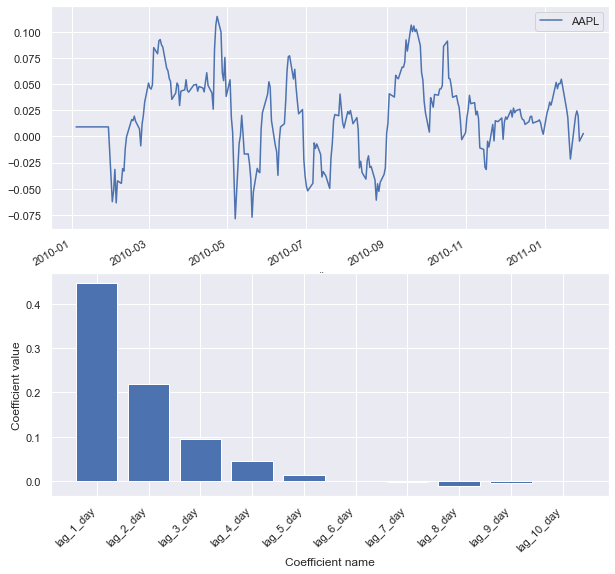

In [50]:
# visualize the output data up to '2011-01'
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

y.loc[:'2011-01'].plot(ax=axs[0])

# run the fxn to viz model's coefs
visualize_coefficients(model.coef_.reshape(-1), price_perc_shifted.columns, ax=axs[1])
plt.show()

From these time-lagged features, we see that the highest coefficient by far is the first one. This means that the $(N-1)^{th}$ time point is useful in predicting the $N^{th}$ timepoint.

## Auto-regression with a smoother time series

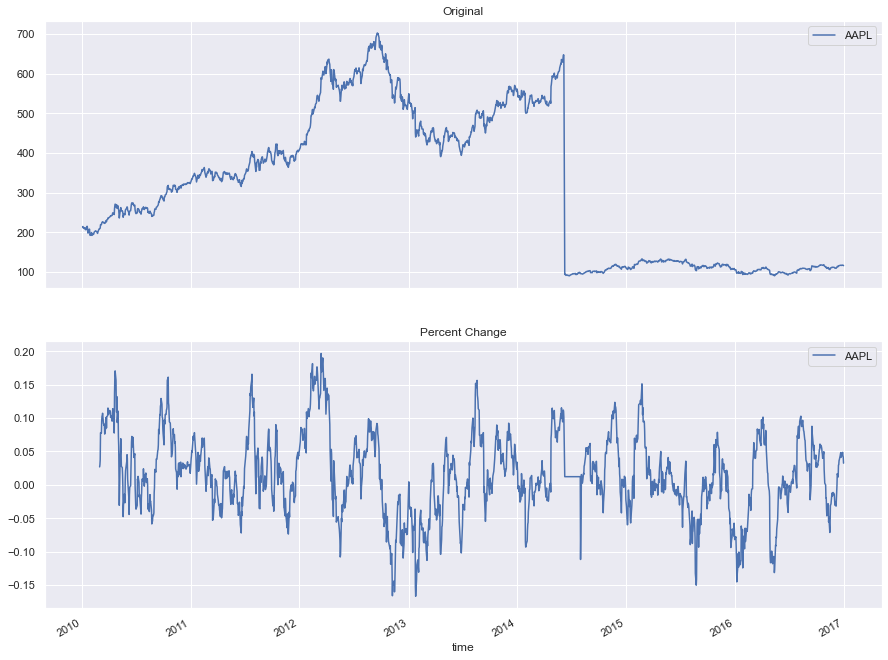

In [52]:
# use a window size of 40 instead of 20
price_perc = price.rolling(40).aggregate(percent_change)
price_perc = price_perc.apply(replace_outliers)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12),
                               sharex=True)

price.plot(ax=ax1)
price_perc.plot(ax=ax2)

ax1.set(title='Original')
ax2.set(title='Percent Change')

plt.show()

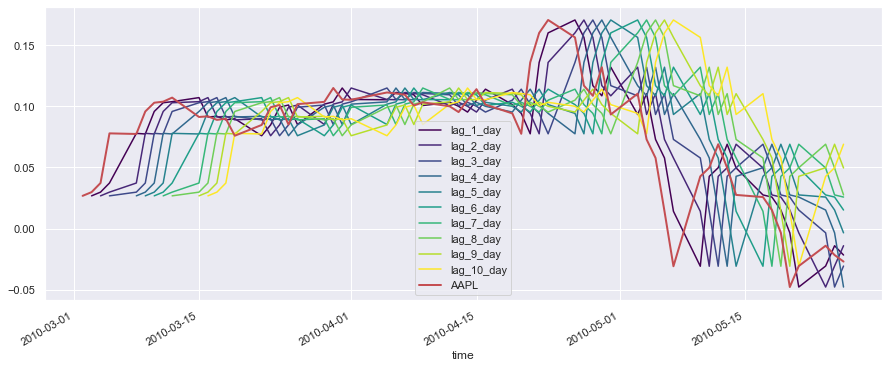

In [53]:
# these are the "time lags"
shifts = np.arange(1, 11).astype(int)

# use dictionary comprehension to create name:value pairs,
# one pair per shift
shifted_data = {f'lag_{day_shift}_day': price_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# convert into a DataFrame for subsequent use
price_perc_shifted = pd.DataFrame(shifted_data)

# plot the first 100 samples of each
fig, ax = plt.subplots(figsize=(15, 6))

price_perc_shifted.iloc[:100].plot(ax=ax,
                                   cmap=plt.cm.viridis)
price_perc.iloc[:100].plot(ax=ax,
                           color='r', lw=2)
ax.legend(loc='best')

plt.show()

In [54]:
# replace missing values with the median for each column
X = price_perc_shifted.fillna(np.nanmedian(price_perc_shifted))
y = price_perc.fillna(np.nanmedian(price_perc))

# fit a Ridge model
model = Ridge()
model.fit(X, y)

Ridge()

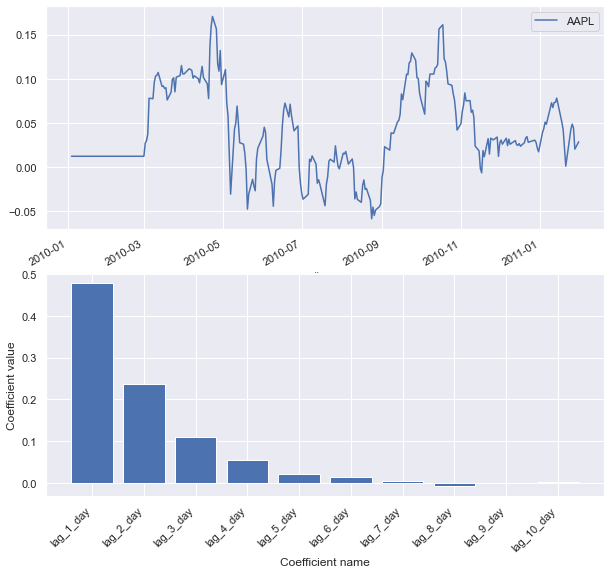

In [55]:
# visualize the output data up to '2011-01'
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

y.loc[:'2011-01'].plot(ax=axs[0])

# run the fxn to viz model's coefs
visualize_coefficients(model.coef_.reshape(-1), price_perc_shifted.columns, ax=axs[1])
plt.show()

As seen here, by transforming the data with a larger window, the relationship between each timepoint and the ones that come just before it have changed (by a bit). This model's coefs gradually go down to zero, which means that the signal itself is smoother over time. Be careful when you see something like this, as it means your data is not i.i.d.

# Some stock data

In [63]:
X = pd.read_csv('./stock_10x.csv', index_col=0).to_numpy()
y = pd.read_csv('./stock_10y.csv', index_col=0).to_numpy()

## Cross-validation with shuffling

In [70]:
#function to visualize results
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, 
                       label=f'Iteration {ii}')

        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc=(1.1, 0.1))
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")

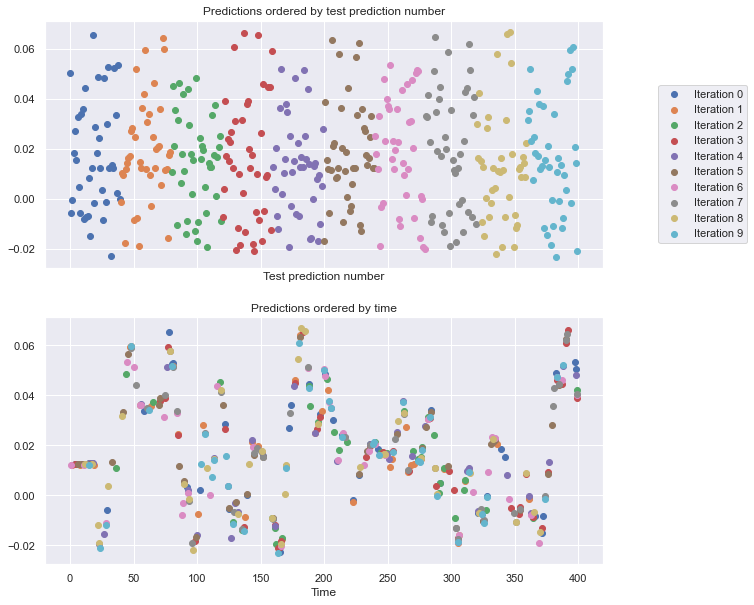

In [71]:
# create cv object
cv = ShuffleSplit(n_splits=10, random_state=1)

# iterate through cv splits
results = []
model = Ridge()
for tr, tt in cv.split(X, y):
    # fit model to training
    model.fit(X[tr], y[tr])
    
    # generate preds on test data, score preds, and collect
    y_pred = model.predict(X[tt])
    score = r2_score(y[tt], y_pred)
    results.append((y_pred, score, tt))
    
# visualize preds
visualize_predictions(results)

In this method, the order of datapoints in the test set is scrambled, which is not very helpful. We'll see how it looks when we shuffle the data in blocks.

## Cross-validation without shuffling

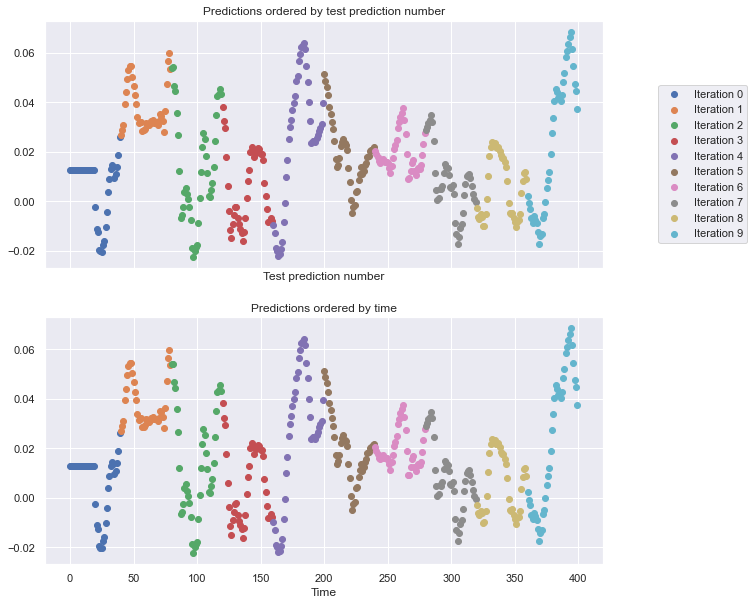

In [75]:
# create KFold cv obj
cv = KFold(n_splits=10, shuffle=False)

# iterate through splits
results = []
model = Ridge()
for tr, tt in cv.split(X, y):
    # fit
    model.fit(X[tr], y[tr])
    
    # eval
    y_pred = model.predict(X[tt])
    score = r2_score(y[tt], y_pred)
    results.append((y_pred, score, tt))
    
# visualize
visualize_predictions(results)

This time, preds generated within each CV loop look 'smoother' than before - they look more like a real time series because the data wasn't shuffled. This is a good sanity check to make sure CV splits are correct.

## Time-based cross-validation

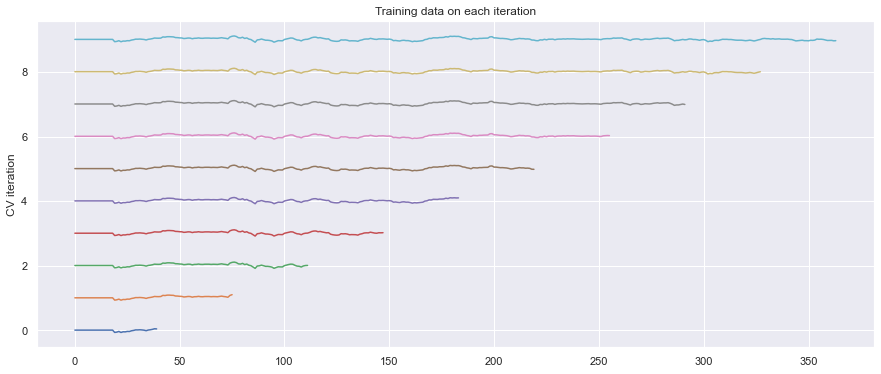

In [77]:
# create a time-series cv obj
cv = TimeSeriesSplit(n_splits=10)

# iterate through CV splits
fig, ax = plt.subplots(figsize=(15, 6))

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii+y[tr])
    
ax.set(title='Training data on each iteration',
       ylabel='CV iteration')

plt.show()

Note that the size of the training set grows at each iteration. This way, the time points you predict are always *after* the timepoints we train on.

**Stationarity and stability**
* Stationary time series do not change there statistical properties over time
* E.g., mean, standard deviation, trends
* Most time series are non-stationary to some extent

**Model stability**
* Non-stationary data results in variability in our model
* The statistical properties the model finds may change with the data
* In addition, we will be less certain about the correct values of model parameters

# Some stock data II

## Bootstrapping a confidence interval

In [130]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    '''Bootstrap a confidence inverval for 
       the mean of columns of a 1D/2D dataset'''
    # create empty array to fill the results
    if data.ndim == 1:
        data = data[:, np.newaxis]
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    
    for ii in range(n_boots):
        # generate random indices for our data *with* replacement
        # then take sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # compute the percentiles for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
        
    return percentiles    

## Calculating variability in model coefficients

In [98]:
X = pd.read_csv('./stock_12x.csv', index_col=0).to_numpy()
y = pd.read_csv('./stock_12y.csv', index_col=0).to_numpy()

In [104]:
model = LinearRegression()
# iterate through splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# create empty arraay to collect coefs
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # fit the model
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

In [105]:
feature_names = np.array(['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day',
                          'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day',
                          'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day'])
times_scores = pd.DatetimeIndex(['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
                                 '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
                                 '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
                                 '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
                                 '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
                                 '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
                                 '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
                                 '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
                                 '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
                                 '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
                                 '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
                                 '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
                                 '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
                                 '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
                                 '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28',
                                 '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07',
                                 '2014-07-30', '2014-08-22', '2014-09-17', '2014-10-10',
                                 '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20',
                                 '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28',
                                 '2015-05-21', '2015-06-16', '2015-07-10', '2015-08-04',
                                 '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09',
                                 '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18',
                                 '2016-03-14', '2016-04-07', '2016-05-02', '2016-05-25',
                                 '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31',
                                 '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07'], name='date')

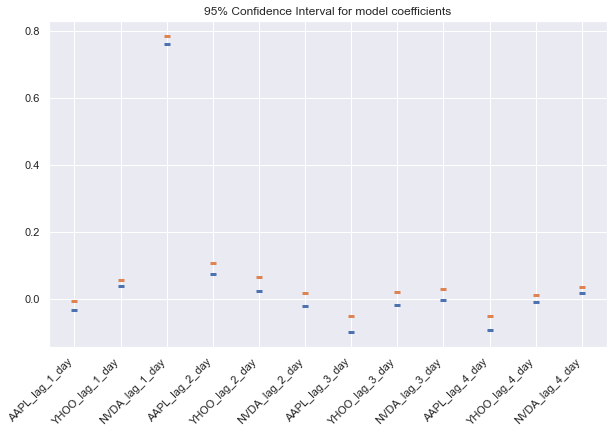

In [106]:
# calculate a confidence interval around each coef
bootstrapped_interval = bootstrap_interval(coefficients)

# plit
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(feature_names, bootstrapped_interval[0],
           marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1],
           marker='_', lw=3)
ax.set(title='95% Confidence Interval for model coefficients')

plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         horizontalalignment='right')

plt.show()

We've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time.

## Visualizing model score variability over time

In [107]:
def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector
    y_pred = est.predict(X).squeeze()
    
    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())
    
    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef_matrix[1, 0]
    return my_corrcoef

In [131]:
model = LinearRegression()
# generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# convert to a pandas series
scores_series = pd.Series(scores, 
                          index=times_scores, 
                          name='score')

# bootstrap a rolling conf interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

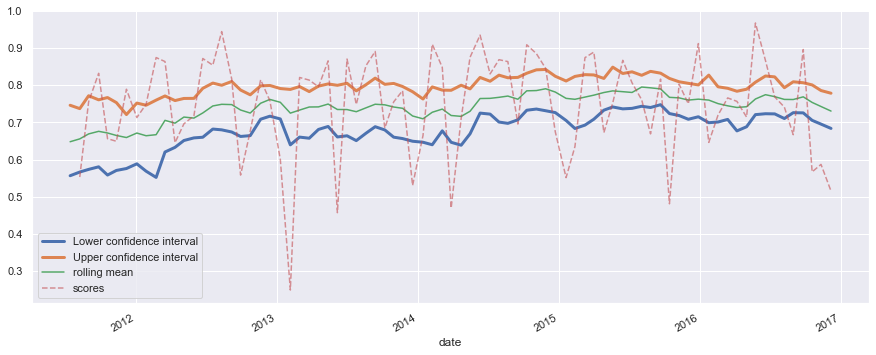

In [141]:
# plot the results
fig, ax = plt.subplots(figsize=(15, 6))

scores_lo.plot(ax=ax,
               label='Lower confidence interval',
               lw=3)
scores_hi.plot(ax=ax,
               label='Upper confidence interval',
               lw=3)
scores_series.rolling(20).mean().plot(ax=ax,
                                      label='rolling mean')
scores_series[20:].plot(ax=ax,
                        label='scores',
                        style='--',
                        alpha=0.6)
ax.legend()

plt.show()

## Accounting for non-stationarity

In [142]:
model = LinearRegression()

# pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# create an empty DataFrame to collect the scores
all_scores = pd.DataFrame(index=times_scores)

# generate scores for each split to see how model performs over time
for window in window_sizes:
    cv = TimeSeriesSplit(n_splits=100, 
                         max_train_size=window)
    
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores[f'Length {window}'] = this_scores

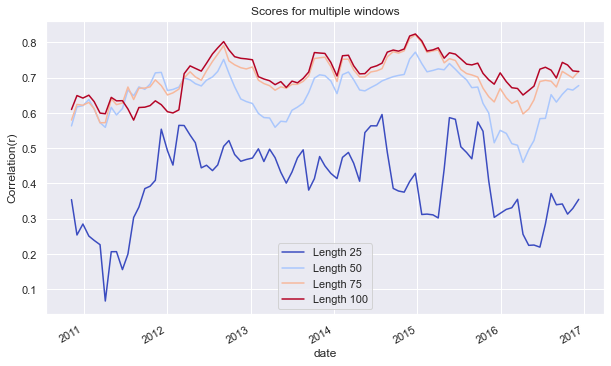

In [143]:
# visualize scores
fig, ax = plt.subplots(figsize=(10, 6))

all_scores.rolling(10).mean().plot(ax=ax,
                                   cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows',
       ylabel='Correlation(r)')

plt.show()